<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_9_Assignment_QnA/Session_9_Assignment_QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import dependencies

In [1]:
!pip install --upgrade albumentations
!pip install torchscan
!pip3 install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### GPU check

In [2]:
import torch
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


### Importing files from github

In [3]:
!ls
!rm -rf .git
!rm -rf eva_base_code
!ls

eva_base_code  sample_data
sample_data


In [4]:
!git clone https://github.com/DimpleB0501/eva_base_code.git

Cloning into 'eva_base_code'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 128 (delta 3), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (128/128), 36.38 KiB | 18.19 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [5]:
cd eva_base_code

/content/eva_base_code


In [6]:
from eva_base_code.models import model9
import main
import utils

### Dataset preparation

In [7]:
import torchvision

In [8]:
mean, std = utils.data_param()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=utils.train_transform_func_9(mean, std)) # RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=utils.test_transform_func(mean, std))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [9]:
batch_size = 512
trainloader, testloader = main.split_data_set(trainset, testset, cuda, batch_size)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model

In [10]:
from torchscan import summary
device = torch.device("cuda" if cuda else "cpu")
model = model9.Net().to(device)
summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

_______________________________________________________________________________
Layer              Type          Output Shape        Param #    Receptive field
net                Net           (-1, 10)            0          1              
├─conv1            Sequential    (-1, 16, 32, 32)    497        3              
├─conv2            Sequential    (-1, 32, 32, 32)    4,737      5              
├─conv3            Sequential    (-1, 48, 32, 32)    14,017     7              
├─gap              Sequential    (-1, 48, 1, 1)      0          38             
├─ultimus_layer    Linear        (-1, 8)             384        38             
├─ultimus_rev      Linear        (-1, 48)            384        38             
├─out              Linear        (-1, 10)            490        38             
Trainable params: 20,314
Non-trainable params: 0
Total params: 20,314
-------------------------------------------------------------------------------
Model size (params + buffers): 0.08 Mb
Framework &

/content/eva_base_code/models/model9.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  AM =  F.softmax(torch.div(torch.matmul(torch.transpose(q, 0, 1), k) , pow(8, 0.5)))


# Test and train loops

In [11]:
num_epochs = 24 # change to 20
#learning_rate = 0.01 #0.025 # change to 0.01

In [12]:
# LRMAX = FIND max learning rate
# max LR finder https://github.com/davidtvs/pytorch-lr-finder
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/100 [00:00<?, ?it/s]

/content/eva_base_code/models/model9.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  AM =  F.softmax(torch.div(torch.matmul(torch.transpose(q, 0, 1), k) , pow(8, 0.5)))


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-03


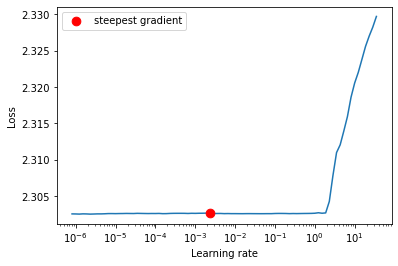

In [13]:
from torch_lr_finder import LRFinder
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
_, lr_suggested = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [14]:
print ("suggested learning rate: ", lr_suggested)
max_learning_rate = lr_suggested #0.025 # change to 0.01

suggested learning rate:  0.0023101297000831605


### Training

In [15]:
# Implemented scheduler in main.py
# Max at Epoch = 5
#pct_start = 0.2 #(~5/24)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, epochs = epochs, steps_per_epoch = len(trainloader), pct_start = pct_start) 

In [16]:
# trigger training
train_acc, train_losses, test_acc, test_losses, l_rate = main.start_training_process(model, device, trainloader, testloader, optimizer = "Adam", learning_rate = max_learning_rate, epochs = num_epochs)

EPOCH: 1


Loss=2.2642996311187744 Batch_id=97 Accuracy=13.38% learning_rate=0.00032249: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.0045, Accuracy: 1517/10000 (15.17%)

EPOCH: 2


Loss=2.264249086380005 Batch_id=97 Accuracy=16.36% learning_rate=0.00091726: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]



Test set: Average loss: 0.0045, Accuracy: 1687/10000 (16.87%)

EPOCH: 3


Loss=2.2067997455596924 Batch_id=97 Accuracy=19.40% learning_rate=0.00162989: 100%|██████████| 98/98 [00:11<00:00,  8.28it/s]



Test set: Average loss: 0.0044, Accuracy: 2020/10000 (20.20%)

EPOCH: 4


Loss=2.2049849033355713 Batch_id=97 Accuracy=21.83% learning_rate=0.00216465: 100%|██████████| 98/98 [00:11<00:00,  8.24it/s]



Test set: Average loss: 0.0044, Accuracy: 2285/10000 (22.85%)

EPOCH: 5


Loss=2.1857433319091797 Batch_id=97 Accuracy=23.77% learning_rate=0.00230945: 100%|██████████| 98/98 [00:11<00:00,  8.17it/s]



Test set: Average loss: 0.0044, Accuracy: 2477/10000 (24.77%)

EPOCH: 6


Loss=2.1501755714416504 Batch_id=97 Accuracy=25.35% learning_rate=0.00228756: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]



Test set: Average loss: 0.0044, Accuracy: 2369/10000 (23.69%)

EPOCH: 7


Loss=2.2764925956726074 Batch_id=97 Accuracy=19.41% learning_rate=0.00223542: 100%|██████████| 98/98 [00:11<00:00,  8.30it/s]



Test set: Average loss: 0.0046, Accuracy: 1689/10000 (16.89%)

EPOCH: 8


Loss=2.26204252243042 Batch_id=97 Accuracy=20.34% learning_rate=0.00215442: 100%|██████████| 98/98 [00:11<00:00,  8.24it/s]



Test set: Average loss: 0.0045, Accuracy: 2268/10000 (22.68%)

EPOCH: 9


Loss=2.302781581878662 Batch_id=97 Accuracy=23.54% learning_rate=0.00204672: 100%|██████████| 98/98 [00:12<00:00,  8.04it/s]



Test set: Average loss: 0.0047, Accuracy: 1268/10000 (12.68%)

EPOCH: 10


Loss=2.2821686267852783 Batch_id=97 Accuracy=16.70% learning_rate=0.00191520: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]



Test set: Average loss: 0.0046, Accuracy: 1679/10000 (16.79%)

EPOCH: 11


Loss=2.27040433883667 Batch_id=97 Accuracy=17.25% learning_rate=0.00176338: 100%|██████████| 98/98 [00:10<00:00,  9.19it/s]



Test set: Average loss: 0.0046, Accuracy: 1739/10000 (17.39%)

EPOCH: 12


Loss=2.2718944549560547 Batch_id=97 Accuracy=18.03% learning_rate=0.00159531: 100%|██████████| 98/98 [00:11<00:00,  8.78it/s]



Test set: Average loss: 0.0045, Accuracy: 2031/10000 (20.31%)

EPOCH: 13


Loss=2.219505548477173 Batch_id=97 Accuracy=19.50% learning_rate=0.00141548: 100%|██████████| 98/98 [00:11<00:00,  8.50it/s]



Test set: Average loss: 0.0045, Accuracy: 2018/10000 (20.18%)

EPOCH: 14


Loss=2.227231502532959 Batch_id=97 Accuracy=20.35% learning_rate=0.00122869: 100%|██████████| 98/98 [00:11<00:00,  8.40it/s]



Test set: Average loss: 0.0045, Accuracy: 2098/10000 (20.98%)

EPOCH: 15


Loss=2.2400453090667725 Batch_id=97 Accuracy=21.23% learning_rate=0.00103993: 100%|██████████| 98/98 [00:11<00:00,  8.29it/s]



Test set: Average loss: 0.0044, Accuracy: 2224/10000 (22.24%)

EPOCH: 16


Loss=2.2332606315612793 Batch_id=97 Accuracy=22.14% learning_rate=0.00085426: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]



Test set: Average loss: 0.0044, Accuracy: 2251/10000 (22.51%)

EPOCH: 17


Loss=2.22607684135437 Batch_id=97 Accuracy=22.81% learning_rate=0.00067661: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Test set: Average loss: 0.0044, Accuracy: 2373/10000 (23.73%)

EPOCH: 18


Loss=2.2057418823242188 Batch_id=97 Accuracy=23.53% learning_rate=0.00051175: 100%|██████████| 98/98 [00:11<00:00,  8.21it/s]



Test set: Average loss: 0.0044, Accuracy: 2437/10000 (24.37%)

EPOCH: 19


Loss=2.236393690109253 Batch_id=97 Accuracy=23.95% learning_rate=0.00036407: 100%|██████████| 98/98 [00:11<00:00,  8.26it/s]



Test set: Average loss: 0.0044, Accuracy: 2433/10000 (24.33%)

EPOCH: 20


Loss=2.206514358520508 Batch_id=97 Accuracy=24.07% learning_rate=0.00023753: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]



Test set: Average loss: 0.0044, Accuracy: 2489/10000 (24.89%)

EPOCH: 21


Loss=2.2162489891052246 Batch_id=97 Accuracy=24.20% learning_rate=0.00013549: 100%|██████████| 98/98 [00:11<00:00,  8.25it/s]



Test set: Average loss: 0.0044, Accuracy: 2465/10000 (24.65%)

EPOCH: 22


Loss=2.1988143920898438 Batch_id=97 Accuracy=24.50% learning_rate=0.00006069: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s]



Test set: Average loss: 0.0044, Accuracy: 2476/10000 (24.76%)

EPOCH: 23


Loss=2.21063232421875 Batch_id=97 Accuracy=24.56% learning_rate=0.00001512: 100%|██████████| 98/98 [00:11<00:00,  8.30it/s]



Test set: Average loss: 0.0044, Accuracy: 2472/10000 (24.72%)

EPOCH: 24


Loss=2.2332217693328857 Batch_id=97 Accuracy=24.58% learning_rate=0.00000001: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]



Test set: Average loss: 0.0044, Accuracy: 2476/10000 (24.76%)



### Plot train and test loss and accuracies

Text(0.5, 1.0, 'Test Accuracy')

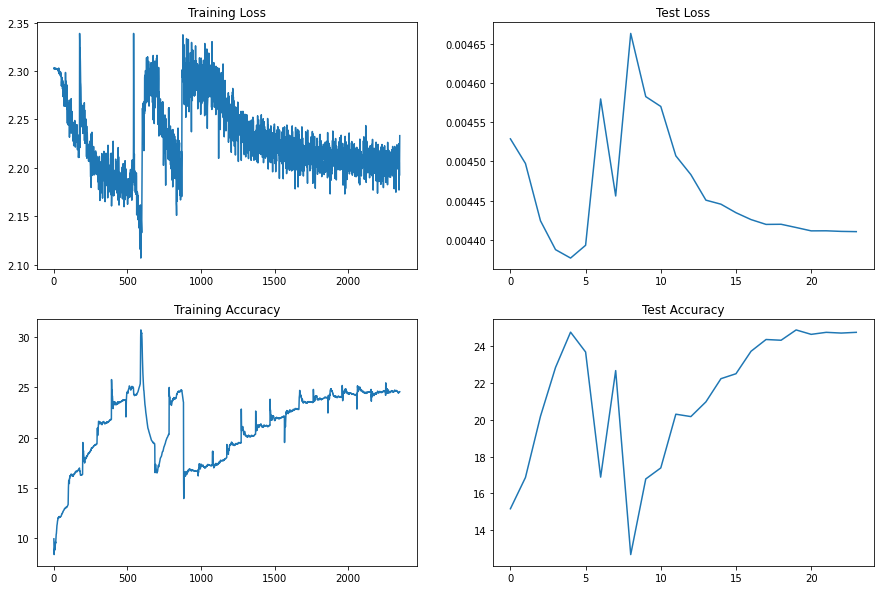

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")